## LAB2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math

## Dodano uczenie metodą propagacji błędu wraz z podejściem batchowym 

In [200]:
class MLP:

    def __init__(self, weights, bias, num_outputs=1, num_hidden=1, activation_function="sigmoid"):
        self.weights = weights
        self.bias = bias
        self.activation_function = activation_function
        self.num_hidden = len(weights) - 1
        self.num_neurons = [weights[0].shape[0]]

        for i in range(len(weights)):
            self.num_neurons.append(weights[i].shape[1])
        self.num_inputs = self.num_neurons[0]
        self.num_outputs = self.num_neurons[-1]

        # verify if dimensions are correct
        for i in range(len(weights) - 1):
            if (weights[i].shape[1] != weights[i + 1].shape[0]):
                print("Weights' dimensions between layers " + str(i) + " and " + str(i + 1) + "are incorrect!")
        for i in range(len(bias)):
            if (weights[i].shape[1] != bias[i].size):
                print("Bias size in layer " + str(i) + " is incorrect!")

        # derivatives of weights and biases used in backpropagation
        self.dw = []
        self.db = []

    def forward_prop(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.a = []
        self.z = []

        activation_function = self.getActivationFunction(self.activation_function)
        activations = inputs
        self.a.append(activations)
        for i in range(self.num_hidden):
            outputs = np.dot(activations, self.weights[i]) + self.bias[i]
            self.z.append(outputs)
            activations = activation_function(outputs)
            self.a.append(activations)

        results = np.dot(activations, self.weights[self.num_hidden]) + self.bias[self.num_hidden]
        self.z.append(results)
        self.a.append(results)
        return results

    def backpropagation(self, y):
        deltas = [None] * len(self.weights)
        deltas[-1] = y - self.a[-1]
        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = (self.weights[i + 1].dot(deltas[i + 1].T) * (
                self.getDerivitiveActivationFunction(self.activation_function)(self.z[i]).T)).T
        
        batch_size = y.shape[0]
        db = [d.T.dot(np.ones((batch_size, 1))).T / float(batch_size) for d in deltas]
        dw = [(d.T.dot(self.a[i])).T / float(batch_size) for i, d in enumerate(deltas)]
        return dw, db

    def train(self, x, y, batch_size = 20, epochs = 500, learning_rate = 0.1, verbose = False):
        for epoch in range(epochs):
            i = 0
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward_prop(x_batch)
                dw, db = self.backpropagation(y_batch)
                self.weights = [w + learning_rate * dweight for w, dweight in zip(self.weights, dw)]
                self.bias = [w + learning_rate * dbias for w, dbias in zip(self.bias, db)]
                if verbose or epoch in [0,epochs-1]:
                    print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.a[-1] - y_batch)))

    @staticmethod
    def getActivationFunction(name):
        if (name == 'sigmoid'):
            return lambda x: np.exp(x) / (1 + np.exp(x))
        elif (name == 'linear'):
            return lambda x: x
        else:
            print('Unknown activation function. linear is used')
            return lambda x: x

    @staticmethod
    def getDerivitiveActivationFunction(name):
        if (name == 'sigmoid'):
            sig = lambda x: np.exp(x) / (1 + np.exp(x))
            return lambda x: sig(x) * (1 - sig(x))
        elif (name == 'linear'):
            return lambda x: 1
        else:
            print('Unknown activation function. linear is used')
            return lambda x: 1

    def show_attributes(self):
        """
    gives basic information about the neural network
    """
        print("Neural Network attributes:")
        print("-------------------------")
        print("Number of neurons in layers: {}".format(self.num_neurons))
        print("Number of predictors: {}".format(self.num_inputs))
        print("Number of hidden layers: {}".format(self.num_hidden))
        print("Number of targets: {}".format(self.num_outputs))
        print("Activations function used: {}".format(self.activation_function))
        return
    
    def visualize(self, axis = False):
        x = []
        y = []
        all_weights = []
        all_biases = [None]
        
        for weight in self.weights:
            for row in weight:
                for i in row:
                    all_weights.append(round(i,2))
        for bias in self.bias:
            for row in bias:
                for i in row:
                    all_biases.append(round(i,2))
        weight_counter = 0
        bias_counter = 0
        
        plt.figure(figsize=(20,10))
        
        for i, layer in enumerate(self.num_neurons):
            #for in in 
            
            layer_points_x = [i] * layer
            layer_points_y = np.linspace(-10, 10, num=layer)
            if layer == 1:
                layer_points_y[0] += 10
            if i==0:
                    previous_layer_x = layer_points_x
                    previous_layer_y = layer_points_y
            else:
                for l1 in previous_layer_y:
                    for l2 in layer_points_y:
                        plt.plot([i-1, i],[l1, l2], color="lightblue")
                        plt.text(i-0.3,0.3*l1+0.7*l2, all_weights[weight_counter], size=15)
                        weight_counter += 1
                previous_layer_x = layer_points_x
                previous_layer_y = layer_points_y
            
            x.extend(layer_points_x)
            y.extend(layer_points_y)
            
        plt.scatter(x,y, color="brown", s=75)
        
        for i, txt in enumerate(all_biases):
            plt.annotate(txt, (x[i], y[i]+0.5), size=15)
        if not axis:
            plt.axis("off")
        plt.title("Neural network graph", fontsize=20)
        plt.show()
        return


def generate_random_mlp(num_inputs, num_hidden, num_targets, start=-10, stop=10):
    """
    generates mlp with random weights given number of neurons in each layer
    """
    weights = []
    bias = []
    weights.append(np.random.uniform(start, stop, num_inputs * num_hidden[0]).reshape(num_inputs, -1))
    for i in range(len(num_hidden) - 1):
        weights.append(np.random.uniform(start, stop, num_hidden[i] * num_hidden[i + 1]).reshape(num_hidden[i], -1))
        bias.append(np.random.uniform(start, stop, num_hidden[i]).reshape(1, -1))
    weights.append(np.random.uniform(start, stop, num_hidden[-1] * num_targets).reshape(-1, num_targets))
    bias.append(np.random.uniform(start, stop, num_hidden[-1]).reshape(1, -1))
    bias.append(np.random.uniform(start, stop, num_targets).reshape(1, -1))
    mlp = MLP(weights, bias)
    return mlp

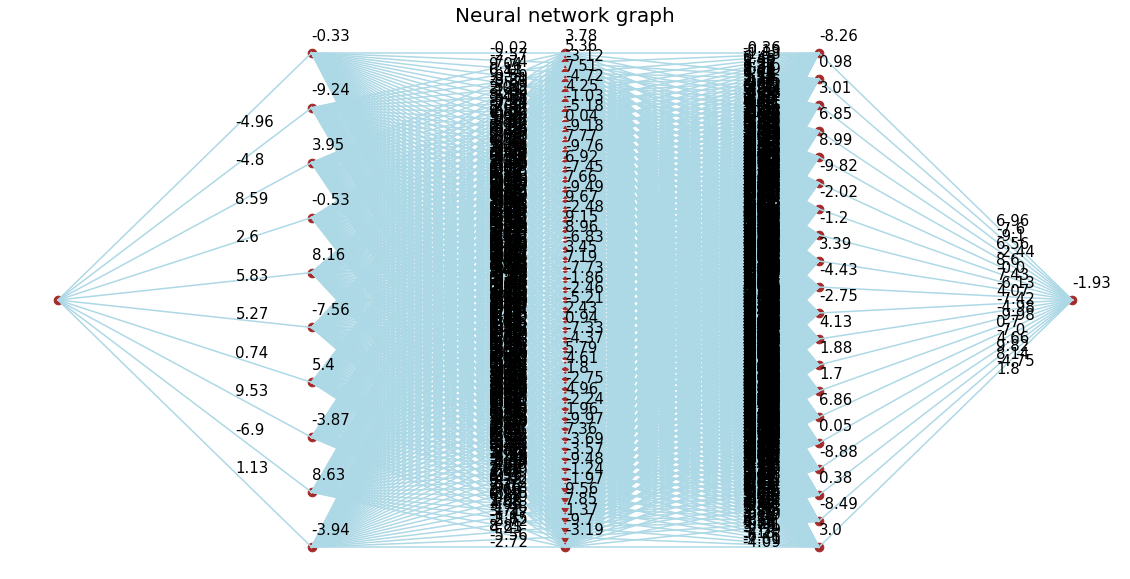

In [203]:
mymlp = generate_random_mlp(1,[10,50,20],1)
mymlp.visualize()

Zainicjujmy losową sieć i sprawdźmy jak nauczy się wzoru paraboli

In [204]:
mymlp = generate_random_mlp(1,[5],1)

In [205]:
mymlp.show_attributes()

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 5, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid


In [206]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/square-simple-test.csv', index_col=0)

In [207]:
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])
df

,x,y,split
1,-0.171543,-127.351580,train
2,0.025201,-129.942844,train
3,-1.368991,38.672367,train
4,1.907390,197.432191,train
5,0.011129,-129.988852,train
...,...,...,...
96,1.315377,25.719403,test
97,-1.196968,-1.054107,test
98,1.544766,84.767303,test
99,0.441051,-112.492699,test


Text(0.5, 1.0, 'Train split')

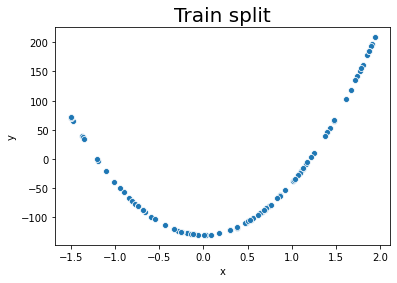

In [208]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

In [209]:
mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
mymlp.show_attributes()

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 5, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid


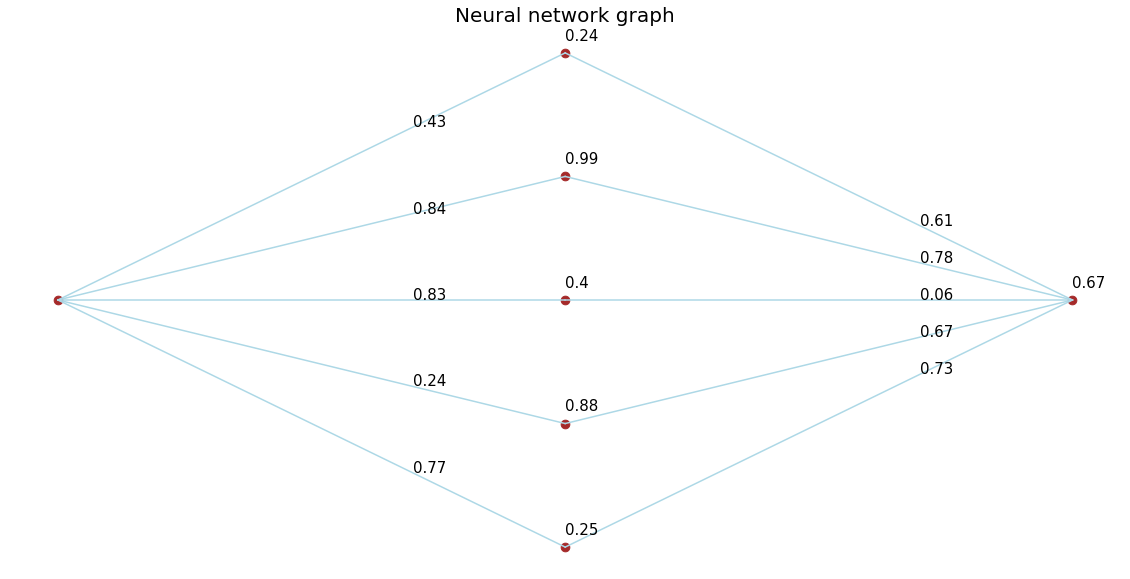

In [210]:
mymlp.visualize()

In [211]:
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 100, 30000, 0.001)

Error in epoch 0 = 1012.3948043621414
Error in epoch 29999 = 480.0698890250367


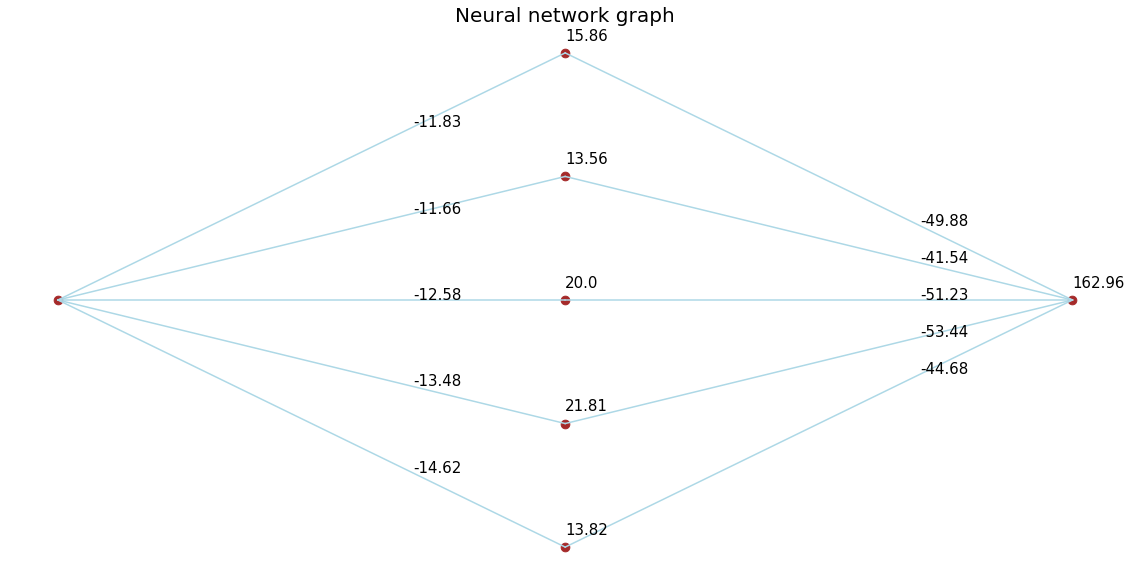

In [212]:
mymlp.visualize()

In [213]:
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))

Text(0.5, 1.0, 'Test performance')

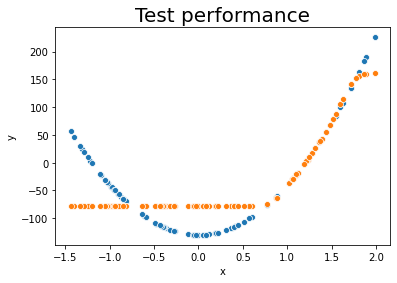

In [214]:
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance', fontsize=20)

Sieć uczy się prawidłowo, jednak to dobrego ustawienia wag potrzebny jest mały krok oraz duża liczba iteracji.

Sprawdżmy w jakim stopniu propagacja wsteczna błędu przyda się do ulepszenia sieci z poprzedniego tygodnia. Wyglądała wtedy następująco:

In [11]:
weights_1 = [np.array([[1, 1, 1, 1, 1]]), np.array([[900], [200], [0], [-200], [-900]])]
bias_1 = [np.array([-2, -1, 0, 1, 2]), np.array([650])]
mlp_1 = MLP(weights=weights_1, bias=bias_1)
mlp_1.show_attributes()

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 5, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid


Text(0.5, 1.0, 'Train performance')

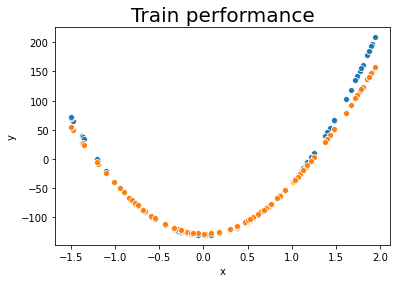

In [12]:
res = mlp_1.forward_prop(np.asarray(train_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=train_df)
sns.scatterplot(x=train_df['x'], y=np.concatenate(res))
plt.title('Train performance', fontsize=20)

Po użyciu zaimplementowanej techniki:

In [13]:
mlp_1.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 200, 1000, 0.00001)

Error in epoch 0 = 151.06991213082432
Error in epoch 999 = 38.33499705409695


Text(0.5, 1.0, 'Test performance')

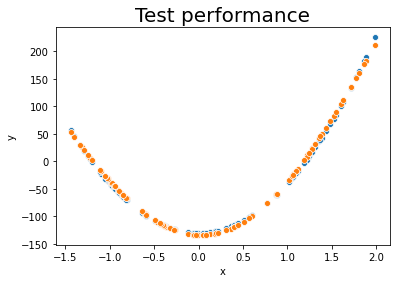

In [14]:
res = mlp_1.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(res))
plt.title('Test performance', fontsize=20)

Test wypadł zdecydowanie dobrze. Przy 1000 epokach sieć lepiej przewiduje obserwacje na "ogonach" paraboli.

### Drugi zbiór

In [21]:
train_df = pd.read_csv('/home/szwagier/Documents/Sem6/MIO/datasets/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('/home/szwagier/Documents/Sem6/MIO/datasets/regression/steps-large-test.csv', index_col=0)

In [22]:
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])
df

,x,y,split
1,-1.481354,-80,train
2,1.033264,80,train
3,-0.076403,0,train
4,-1.419785,-80,train
5,-0.108398,0,train
...,...,...,...
996,-1.374447,-80,test
997,-0.764941,-80,test
998,-0.304863,0,test
999,1.681272,160,test


Text(0.5, 1.0, 'Train split')

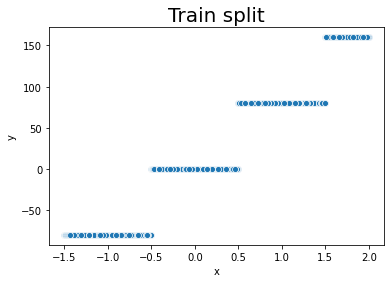

In [23]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

In [25]:
mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
mymlp.show_attributes()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 1000, 10000, 0.1)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 5, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Error in epoch 0 = 2742.1751409787817
Error in epoch 0 = 2553.773995845125
Error in epoch 0 = 2266.2402205565195
Error in epoch 0 = 2045.0620972530905
Error in epoch 0 = 2001.2218793392228
Error in epoch 0 = 1829.5139525989232
Error in epoch 0 = 1773.7256135973098
Error in epoch 0 = 1726.1298027204039
Error in epoch 0 = 1643.1673414649056
Error in epoch 0 = 1632.0709079824492
Error in epoch 9999 = 133.50762182809208
Error in epoch 9999 = 110.27351984878001
Error in epoch 9999 = 115.09973362819105
Error in epoch 9999 = 90.361353475302
Error in epoch 9999 = 117.5453758946459
Error in epoch 9999 = 110.56664021375686
Error in epoch 9999 = 100.75415639699264
Error in epoch 9999 = 119.36109722021051
Error in epoch 9999 = 105.71965804942923
Error in epoch 9999 = 93.5708500135998


Text(0.5, 1.0, 'Test performance')

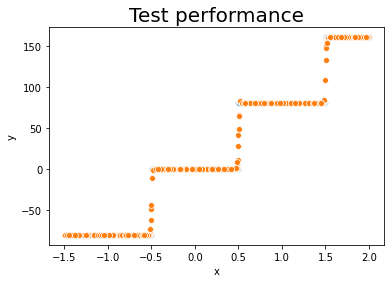

In [26]:
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance', fontsize=20)

In [23]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-test.csv', index_col=0)

In [24]:
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])
df

,x,y,split
1,-0.685726,-80,train
2,-0.879898,-80,train
3,1.411932,80,train
4,1.688954,160,train
5,-0.573238,-80,train
...,...,...,...
996,-0.991285,-80,test
997,1.122065,80,test
998,1.193833,80,test
999,-0.459627,0,test


Text(0.5, 1.0, 'Train split')

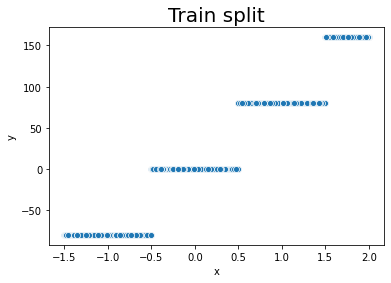

In [25]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

In [26]:
mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
mymlp.show_attributes()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 1000, 10000, 0.1)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 5, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Error in epoch 0 = 2656.740316518015
Error in epoch 0 = 2447.603680291802
Error in epoch 0 = 2379.8014853949853
Error in epoch 0 = 2221.017392873763
Error in epoch 0 = 1982.639642249851
Error in epoch 0 = 1833.8767153751085
Error in epoch 0 = 1764.1550268797916
Error in epoch 0 = 1794.4384359757112
Error in epoch 0 = 1666.150811724045
Error in epoch 0 = 1570.281647102751
Error in epoch 9999 = 108.39896253228383
Error in epoch 9999 = 122.3844360049436
Error in epoch 9999 = 105.50296656128508
Error in epoch 9999 = 109.98040941236889
Error in epoch 9999 = 65.5795007870575
Error in epoch 9999 = 137.55604792367168
Error in epoch 9999 = 121.99658070002828
Error in epoch 9999 = 78.07250582573471
Error in epoch 9999 = 111.98645318847093
Error in epoch 9999 = 102.69692944295558


Text(0.5, 1.0, 'Test performance')

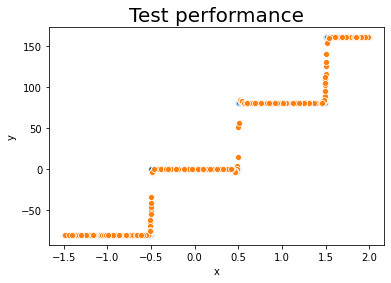

In [28]:
res = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(res))
plt.title('Test performance', fontsize=20)

In [49]:
y1 = [1,2,3,4]
y2 = [1,2]
for i,j in zip(y1, y2):
    print(i,j)

1 1
2 2
